# 2 Modeling

Now that I have collected the training, validation, and test images, I pre-processed the images and utilized the following CNN architectures:

<ul>
  <li>Simple CNN with two convolutional layers</li>
  <li>AlexNet</li>
  <li>ResNet50</li>
  <li>Adapted ResNet50 with an additional fully connected layer</li>
</ul>

## 2.1 Importing packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from keras.applications import ResNet50
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

## 2.2 Pre-Processing

### 2.2.1 Create image data generators
I used keras's ImageDataGenerator to create data generators from the directories created in the previous notebook. For data augmentation, I included rotation as well as width and height shifting for the training generator. I used ResNet50's preprocess_input function for preprocessing, which zero centers all color channels with respect to the Imagenet dataset, but does not normalize them. This is necessary as I will use the pre-trained weights of the ResNet50 model.

In [2]:
IMAGE_SIZE = 224
SEED = 44

# Initialize image data generator using the ResNet50's preprocess_input function.
training_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=10,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    )
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


# Create train, validation, and test generators from full directories
train_generator = training_generator.flow_from_directory(
        '../data/processed/full/train',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        class_mode='binary',
        seed=SEED)

validation_generator = val_generator.flow_from_directory(
        '../data/processed/full/validation',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        class_mode='binary',
        seed=SEED)

test_generator = val_generator.flow_from_directory(
        '../data/processed/full/test',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        class_mode='binary',
        seed=SEED)

# Create train and validation generators for partial set of 1000 images
train_generator500 = training_generator.flow_from_directory(
        '../data/processed/partial/train',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        class_mode='binary',
        seed=SEED)

validation_generator500 = val_generator.flow_from_directory(
        '../data/processed/partial/validation',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        class_mode='binary',
        seed=SEED)

Found 3330 images belonging to 2 classes.
Found 1112 images belonging to 2 classes.
Found 1110 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### 2.2.2 Visualizing preprocessed image

Image dimensions: 224 x 224 pixels
Maximum pixel value: 149.2555
Minimum pixel value: -123.6800
Mean pixel value: 12.3262
Standard deviation: 64.1593


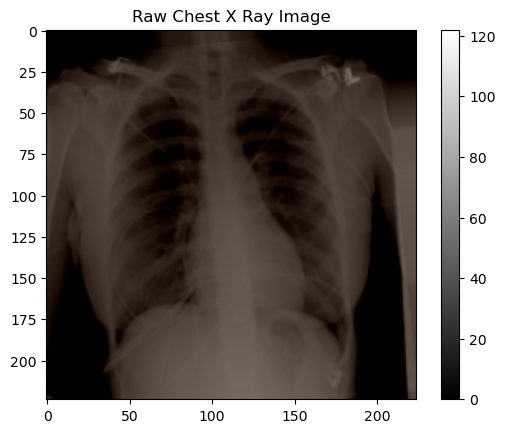

In [3]:
# Collect batch of processed images
generated_image, label = train_generator.__getitem__(0)
# Plot one image
plt.imshow(generated_image[0].astype('uint32'), cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"Image dimensions: {generated_image.shape[1]} x {generated_image.shape[2]} pixels")
print(f"Maximum pixel value: {generated_image.max():.4f}")
print(f"Minimum pixel value: {generated_image.min():.4f}")
print(f"Mean pixel value: {generated_image.mean():.4f}")
print(f"Standard deviation: {generated_image.std():.4f}")

## 2.3 Initial modeling

In [4]:
# Initalize lists for future model_results dataframe
model_names = []
create_model_functions = []
initial_val_loss = []
initial_val_accuracy = []
initial_val_precision = []
initial_val_recall = []

In [5]:
def plot_acc_loss(history, model_name, xlabel = 'Epoch #'):

    if hasattr(history, 'history_'):
        history = history.history_
    else:
        history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)
    
    # Store best val_loss, val_accuracy, val_precision, and val_recall
    best = history.sort_values(by = 'val_loss').iloc[0]
    best_val_loss = best['val_loss']
    best_val_accuracy = best['val_accuracy']
    best_val_precision = best['val_precision']
    best_val_recall = best['val_recall']
    
    # Append lists for model_results dataframe to come
    model_names.append(model_name)
    initial_val_loss.append(best_val_loss)
    initial_val_accuracy.append(best_val_accuracy)
    initial_val_precision.append(best_val_precision)
    initial_val_recall.append(best_val_recall)

    # Create subplots
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    # Plot accuracy
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax[0])
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax[0])
    ax[0].legend(loc = 9)
    ax[0].set_ylim([0, 1])

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Accuracy (Fraction)')
    ax[0].set_title(f'Accuracy for {model_name} model')

    # Plot loss
    sns.lineplot(x = 'epoch', y = 'val_loss', data = history, label = 'Validation', ax = ax[1])
    sns.lineplot(x = 'epoch', y = 'loss', data = history, label = 'Training', ax = ax[1])
    ax[1].legend(loc = 9)
    ax[1].set_ylim([0, 1])

    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Loss')
    ax[1].set_title(f'Loss for {model_name} model')

    plt.show()

In [6]:
def initial_model_test(model, model_name):
    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
    history = model.fit(train_generator,
                       validation_data=validation_generator,
                       epochs=10,
                       callbacks=[cb_early_stopper]
                      )
    plot_acc_loss(history, model_name)

### 2.3.1 Initial Simple CNN

I created a simple CNN with the following architecture:

<ul>
  <li>Convolutional layer with 96 filters of size 11x11 with a stride of 3, activated by relu</li>
  <li>Max pooling layer</li>
  <li>Convolutional layer with 32 filters of size 5x5, activated by relu</li>
  <li>Max pooling layer</li>
  <li>Dense layer with 512 neurons activated by relu</li>
  <li>Output layer with 1 neuron activated by sigmoid function</li>
</ul>

In [7]:
def create_cnn(image_size=IMAGE_SIZE, learning_rate=0.0001):
    # Initialize model
    model = Sequential()
    model.add(Input(shape=(image_size, image_size, 3)))

    # Add first convolutional layer
    model.add(Conv2D(96, 11, strides = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add second convolutional layer
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(layers.Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Initiate Adam optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=1e-6)

    # Complile with the optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model

In [8]:
# Create a cnn model and add the function to the list of create model functions
cnn = create_cnn()
create_model_functions.append(create_cnn)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 72, 72, 96)        34944     
                                                                 
 activation (Activation)     (None, 72, 72, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 32)        76832     
                                                                 
 activation_1 (Activation)   (None, 36, 36, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                    

Epoch 1/10


2023-09-18 14:29:59.743968: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


105/105 [==============================] - 67s 635ms/step - loss: 1.7910 - accuracy: 0.5366 - precision: 0.5360 - recall: 0.5459 - val_loss: 0.6835 - val_accuracy: 0.5360 - val_precision: 0.5319 - val_recall: 0.5989
Epoch 2/10
105/105 [==============================] - 67s 639ms/step - loss: 0.6978 - accuracy: 0.5502 - precision: 0.5473 - recall: 0.5802 - val_loss: 0.6552 - val_accuracy: 0.6052 - val_precision: 0.6410 - val_recall: 0.4784
Epoch 3/10
105/105 [==============================] - 69s 655ms/step - loss: 0.6878 - accuracy: 0.5589 - precision: 0.5593 - recall: 0.5556 - val_loss: 0.6636 - val_accuracy: 0.5836 - val_precision: 0.5611 - val_recall: 0.7680
Epoch 4/10
105/105 [==============================] - 67s 640ms/step - loss: 0.6874 - accuracy: 0.5760 - precision: 0.5853 - recall: 0.5213 - val_loss: 0.6321 - val_accuracy: 0.6268 - val_precision: 0.6257 - val_recall: 0.6313
Epoch 5/10
105/105 [==============================] - 67s 639ms/step - loss: 0.6771 - accuracy: 0.5931 

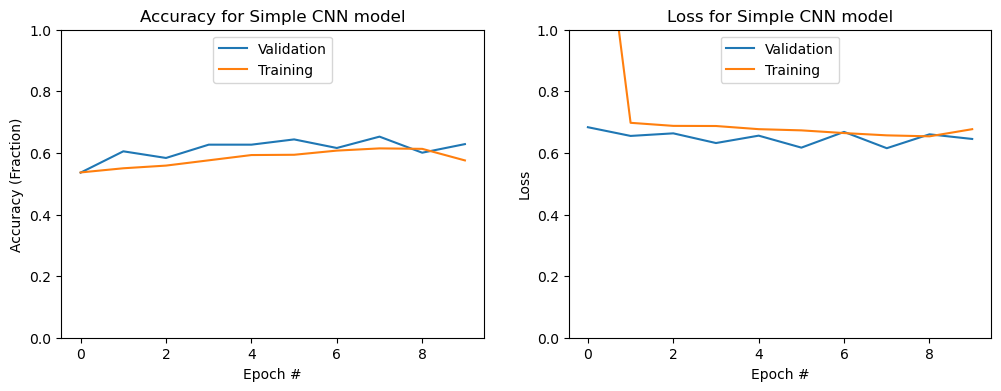

In [9]:
# Train and plot accuracy and loss for the model
initial_model_test(cnn, 'Simple CNN')

### 2.3.2 Initial AlexNet

In [10]:
# Create AlexNet function
def create_alexnet(image_size=IMAGE_SIZE, learning_rate=0.0001):
    an_model = Sequential()
    
    an_model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

    an_model.add(Conv2D(96, 11, strides = 3))
    an_model.add(Activation('relu'))
    an_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    an_model.add(BatchNormalization())

    an_model.add(Conv2D(256, 5))
    an_model.add(Activation('relu'))
    an_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    an_model.add(BatchNormalization())

    an_model.add(Conv2D(384, 3, padding = 'same'))
    an_model.add(Activation('relu'))
    an_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    an_model.add(Conv2D(384, 3, padding = 'same'))
    an_model.add(Activation('relu'))
    an_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    an_model.add(Conv2D(256, 3, padding = 'same'))
    an_model.add(Activation('relu'))
    an_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    an_model.add(Flatten())

    an_model.add(Dropout(0.5))
    an_model.add(Dense(4096))
    an_model.add(Activation('relu'))

    an_model.add(Dropout(0.5))
    an_model.add(Dense(4096))
    an_model.add(Activation('relu'))

    an_model.add(Dense(1))
    an_model.add(Activation('sigmoid'))

    opt = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    an_model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])
    return an_model

In [11]:
an_model = create_alexnet()
create_model_functions.append(create_alexnet)
an_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 72, 72, 96)        34944     
                                                                 
 activation_4 (Activation)   (None, 72, 72, 96)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 36, 36, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       614656    
                                                                 
 activation_5 (Activation)   (None, 32, 32, 256)      

Epoch 1/10
105/105 [==============================] - 77s 724ms/step - loss: 0.7231 - accuracy: 0.5387 - precision: 0.5385 - recall: 0.5417 - val_loss: 0.7180 - val_accuracy: 0.5288 - val_precision: 0.5162 - val_recall: 0.9155
Epoch 2/10
105/105 [==============================] - 76s 723ms/step - loss: 0.6802 - accuracy: 0.5877 - precision: 0.5914 - recall: 0.5676 - val_loss: 0.6269 - val_accuracy: 0.6439 - val_precision: 0.6254 - val_recall: 0.7176
Epoch 3/10
105/105 [==============================] - 76s 722ms/step - loss: 0.6556 - accuracy: 0.6150 - precision: 0.6139 - recall: 0.6198 - val_loss: 0.6397 - val_accuracy: 0.6277 - val_precision: 0.9128 - val_recall: 0.2824
Epoch 4/10
105/105 [==============================] - 76s 722ms/step - loss: 0.6457 - accuracy: 0.6288 - precision: 0.6331 - recall: 0.6126 - val_loss: 0.6050 - val_accuracy: 0.6709 - val_precision: 0.7317 - val_recall: 0.5396
Epoch 5/10
105/105 [==============================] - 76s 724ms/step - loss: 0.6162 - accura

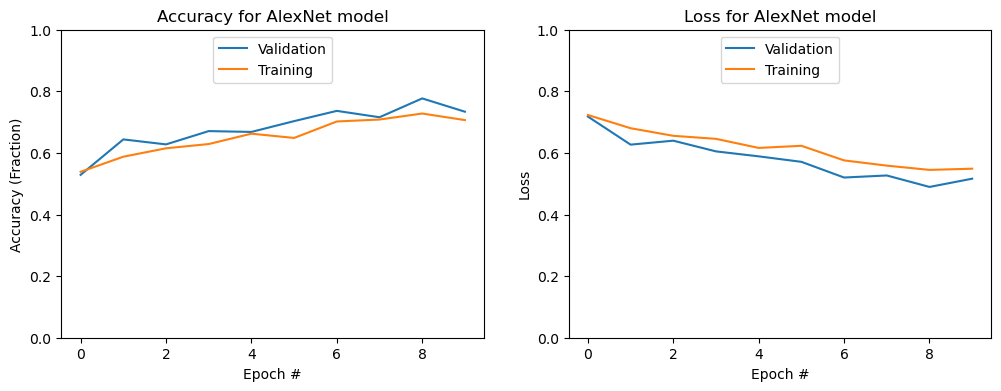

In [12]:
initial_model_test(an_model, "AlexNet")

### 2.3.3 Initial ResNet50

I created a function to incorporate any base model into a neural net with a head model consistent with my binary classification problem

In [13]:
def integrate_into_nn(base_model,
                      learning_rate=0.0001,
                      metrics = ['accuracy',
                                 keras.metrics.Precision(name='precision'),
                                 keras.metrics.Recall(name='recall')]):
    # Create head_model
    head_model = base_model.output
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(1, activation="sigmoid")(head_model)
    # Place the head fully connected model on top of the base model
    model = Model(inputs=base_model.input, outputs=head_model)
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Initiate Adam optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=1e-6)

    # Compile the model using Adam
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=metrics)
    
    return model

In [14]:
def create_resnet50(learning_rate=0.001):
    # initialize ResNet
    rn50 = ResNet50(
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )
    
    # integrate with fully connected layers
    rn50_model = integrate_into_nn(rn50,learning_rate=learning_rate)
    return rn50_model

In [15]:
rn50_model = create_resnet50()
create_model_functions.append(create_resnet50)
rn50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

Epoch 1/10
105/105 [==============================] - 83s 778ms/step - loss: 0.8174 - accuracy: 0.5387 - precision: 0.5396 - recall: 0.5273 - val_loss: 0.6385 - val_accuracy: 0.6106 - val_precision: 0.5997 - val_recall: 0.6655
Epoch 2/10
105/105 [==============================] - 82s 777ms/step - loss: 0.7190 - accuracy: 0.5973 - precision: 0.5977 - recall: 0.5952 - val_loss: 0.6254 - val_accuracy: 0.6358 - val_precision: 0.7352 - val_recall: 0.4245
Epoch 3/10
105/105 [==============================] - 81s 770ms/step - loss: 0.6878 - accuracy: 0.6123 - precision: 0.6160 - recall: 0.5964 - val_loss: 0.5938 - val_accuracy: 0.6727 - val_precision: 0.6771 - val_recall: 0.6601
Epoch 4/10
105/105 [==============================] - 81s 773ms/step - loss: 0.6487 - accuracy: 0.6381 - precision: 0.6429 - recall: 0.6216 - val_loss: 0.5841 - val_accuracy: 0.6745 - val_precision: 0.6932 - val_recall: 0.6259
Epoch 5/10
105/105 [==============================] - 81s 770ms/step - loss: 0.6464 - accura

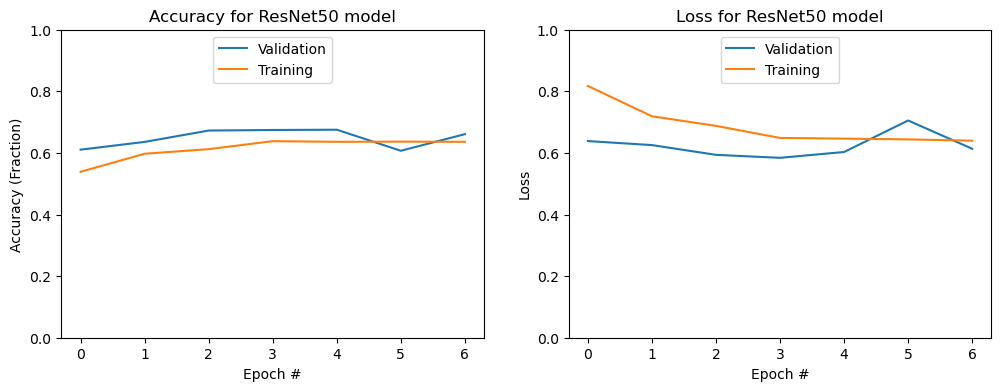

In [16]:
initial_model_test(rn50_model, "ResNet50")

### 2.3.4 Initial Adapted ResNet50
I added an additional average pooling layer and a dense layer to the head model after the ResNet50 base layers.

In [17]:
def create_adapted_resnet50(learning_rate = 0.0001):
    # Create base ResNet50 model
    base_model = ResNet50(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    # Create head model with additional pooling and dense layer
    head_model = base_model.output
    head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(256, activation="relu")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(1, activation="sigmoid")(head_model)
    # Place the head fully connected model on top of the base model
    adapted_rn50 = Model(inputs=base_model.input, outputs=head_model)
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Initiate Adam optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

    # Compile with optimizer
    adapted_rn50.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return adapted_rn50


In [18]:
adapted_rn50_model = create_adapted_resnet50()
create_model_functions.append(create_adapted_resnet50)
adapted_rn50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

Epoch 1/10
105/105 [==============================] - 82s 770ms/step - loss: 0.7599 - accuracy: 0.5628 - precision: 0.5632 - recall: 0.5592 - val_loss: 0.6203 - val_accuracy: 0.6475 - val_precision: 0.6565 - val_recall: 0.6187
Epoch 2/10
105/105 [==============================] - 80s 762ms/step - loss: 0.6674 - accuracy: 0.6165 - precision: 0.6187 - recall: 0.6072 - val_loss: 0.6132 - val_accuracy: 0.6502 - val_precision: 0.7022 - val_recall: 0.5216
Epoch 3/10
105/105 [==============================] - 81s 773ms/step - loss: 0.6228 - accuracy: 0.6508 - precision: 0.6571 - recall: 0.6306 - val_loss: 0.6044 - val_accuracy: 0.6691 - val_precision: 0.7582 - val_recall: 0.4964
Epoch 4/10
105/105 [==============================] - 81s 764ms/step - loss: 0.6138 - accuracy: 0.6480 - precision: 0.6526 - recall: 0.6330 - val_loss: 0.5896 - val_accuracy: 0.6790 - val_precision: 0.6613 - val_recall: 0.7338
Epoch 5/10
105/105 [==============================] - 80s 763ms/step - loss: 0.6202 - accura

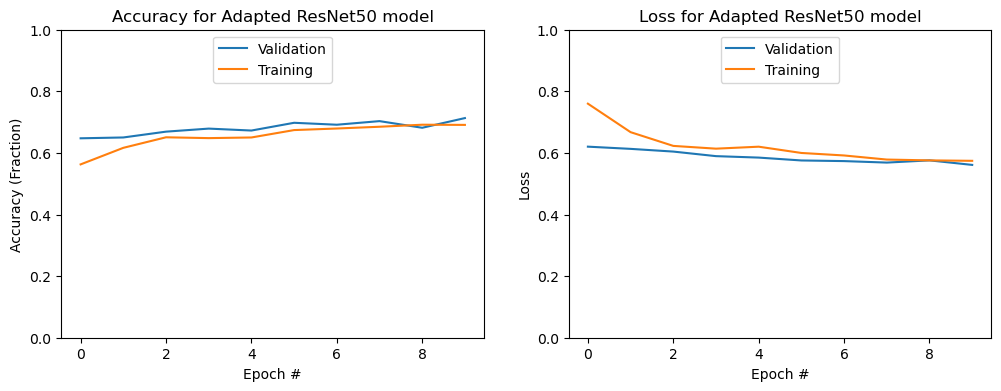

In [19]:
initial_model_test(adapted_rn50_model, "Adapted ResNet50")

### 2.3.5 Inital Results

In [20]:
# Create dictionary
summaries = {
    'model_name': model_names,
    'create_model_function': create_model_functions,
    'initial_val_loss': initial_val_loss,
    'initial_val_accuracy': initial_val_accuracy,
    'initial_val_precision': initial_val_precision,
    'initial_val_recall': initial_val_recall
}

# Convert to dataframe
model_results = pd.DataFrame(summaries)

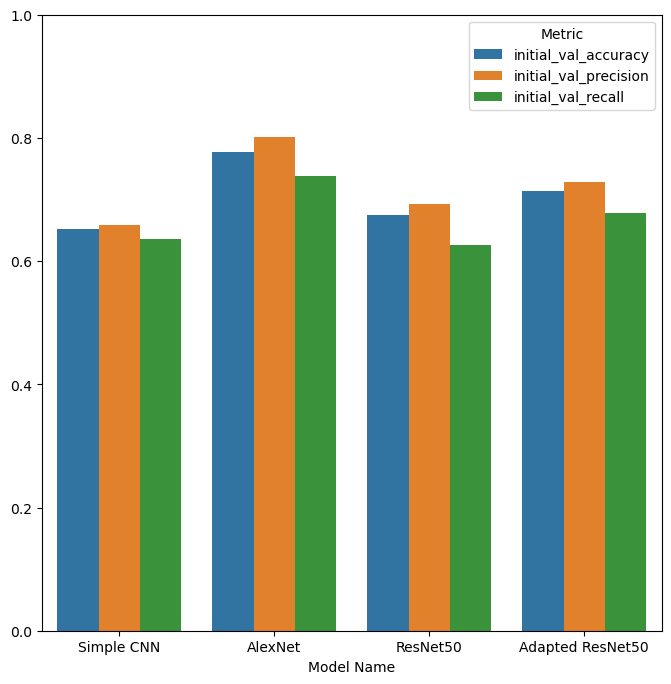

In [21]:
# Melt dataframe to plot all metrics
df_melt = model_results.drop(columns=['create_model_function','initial_val_loss']).melt(id_vars='model_name')

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=df_melt, x='model_name', y='value', hue='variable')
ax.set_ylabel(None)
ax.set_xlabel('Model Name')
ax.set_ylim(0,1)
plt.legend(title='Metric');

## 2.4 Tuning
I then found the optimal learning rates and batch sizes for each model.

### 2.4.1 Tuning learning rate

In [22]:
# function for determining best learning rates
def best_learning_rate(create_model_function,
                           model_name,
                           learning_rates = [1e-4, 1e-5, 1e-6, 1e-7],
                           num_epochs = 10,
                           train_generator = train_generator500,
                           validataion_generator = validation_generator500
                         ):
    # Initialize results list
    results = []
    
    f, ax = plt.subplots(1,1)
    
    # Loop through learning_rates
    for learning_rate in learning_rates:
        print(f'Learning Rate: {learning_rate}')
        
        model = create_model_function(learning_rate = learning_rate)
        
        cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)

        history = model.fit(train_generator500,
                            validation_data = validation_generator500,
                            epochs = num_epochs,
                            callbacks=[cb_early_stopper]
                            )
        if hasattr(history, 'history_'):
            history = history.history_
        else:
            history = history.history
        history.update({'epoch':list(range(len(history['val_loss'])))})
        history = pd.DataFrame.from_dict(history)
        
        # Plot val_loss
        sns.lineplot(x = 'epoch', y = 'val_loss', data = history, label = f'{learning_rate}', ax = ax)
        
        lowest_val_loss = history['val_loss'].min()
        row = (learning_rate, lowest_val_loss)
        results.append(row)
        
    ax.set_ylim(ymin=0)
    plt.legend(title='Learning Rate')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Validation Loss')
    plt.title(f"Comparison of Learning Rates for {model_name}")

    plt.show()
    
    # Determine best learning rate
    df = pd.DataFrame(results, columns=['learning_rate', 'lowest_val_loss'])
    best_learning_rate = df.sort_values('lowest_val_loss').iloc[0,0]
    lowest_val_loss = df['lowest_val_loss'].min()
    print(f'Best learning rate: {best_learning_rate}')
    print(f'Lowest val loss: {lowest_val_loss:.4f}')
    
    return best_learning_rate

Learning Rate: 0.0001
Epoch 1/10
25/25 [==============================] - 16s 616ms/step - loss: 5.5319 - accuracy: 0.5138 - precision: 0.5144 - recall: 0.4925 - val_loss: 0.9318 - val_accuracy: 0.5750 - val_precision: 0.5472 - val_recall: 0.8700
Epoch 2/10
25/25 [==============================] - 16s 619ms/step - loss: 0.9864 - accuracy: 0.5188 - precision: 0.5174 - recall: 0.5575 - val_loss: 0.7157 - val_accuracy: 0.5550 - val_precision: 0.5414 - val_recall: 0.7200
Epoch 3/10
25/25 [==============================] - 15s 603ms/step - loss: 0.7926 - accuracy: 0.5312 - precision: 0.5278 - recall: 0.5925 - val_loss: 0.6880 - val_accuracy: 0.5400 - val_precision: 0.5392 - val_recall: 0.5500
Epoch 4/10
25/25 [==============================] - 15s 600ms/step - loss: 0.7204 - accuracy: 0.5688 - precision: 0.5693 - recall: 0.5650 - val_loss: 0.6862 - val_accuracy: 0.5650 - val_precision: 0.5520 - val_recall: 0.6900
Epoch 5/10
25/25 [==============================] - 15s 601ms/step - loss: 0.7

25/25 [==============================] - 15s 610ms/step - loss: 7.9955 - accuracy: 0.5063 - precision: 0.5055 - recall: 0.5775 - val_loss: 2.7091 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8200
Epoch 9/10
25/25 [==============================] - 15s 604ms/step - loss: 7.8117 - accuracy: 0.5050 - precision: 0.5043 - recall: 0.5800 - val_loss: 2.4842 - val_accuracy: 0.5050 - val_precision: 0.5033 - val_recall: 0.7600
Epoch 10/10
25/25 [==============================] - 15s 603ms/step - loss: 7.1398 - accuracy: 0.5325 - precision: 0.5304 - recall: 0.5675 - val_loss: 2.4108 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7500


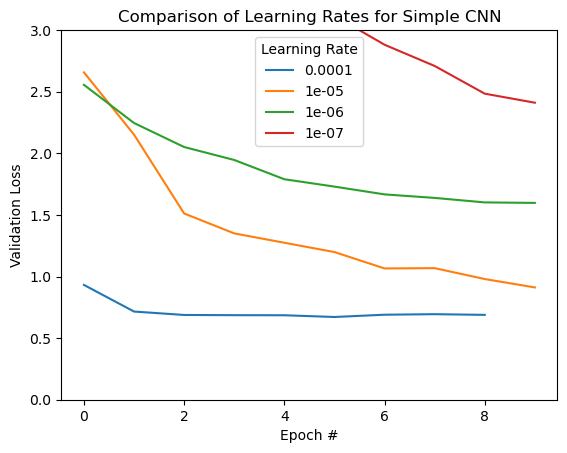

Best learning rate: 0.0001
Lowest val loss: 0.6715


In [23]:
cnn_learning_rate = best_learning_rate(create_cnn, "Simple CNN")

Learning Rate: 0.0001
Epoch 1/10
25/25 [==============================] - 18s 689ms/step - loss: 0.7831 - accuracy: 0.5100 - precision: 0.5097 - recall: 0.5275 - val_loss: 0.7541 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
25/25 [==============================] - 18s 699ms/step - loss: 0.6817 - accuracy: 0.5587 - precision: 0.5575 - recall: 0.5700 - val_loss: 0.6752 - val_accuracy: 0.6350 - val_precision: 0.9091 - val_recall: 0.3000
Epoch 3/10
25/25 [==============================] - 17s 680ms/step - loss: 0.6569 - accuracy: 0.5975 - precision: 0.5985 - recall: 0.5925 - val_loss: 0.6273 - val_accuracy: 0.6650 - val_precision: 0.6634 - val_recall: 0.6700
Epoch 4/10
25/25 [==============================] - 17s 678ms/step - loss: 0.6874 - accuracy: 0.5888 - precision: 0.5881 - recall: 0.5925 - val_loss: 0.6364 - val_accuracy: 0.6500 - val_precision: 0.7419 - val_recall: 0.4600
Epoch 5/10
25/25 [==============================] - 17s 687ms/step - loss: 0.6

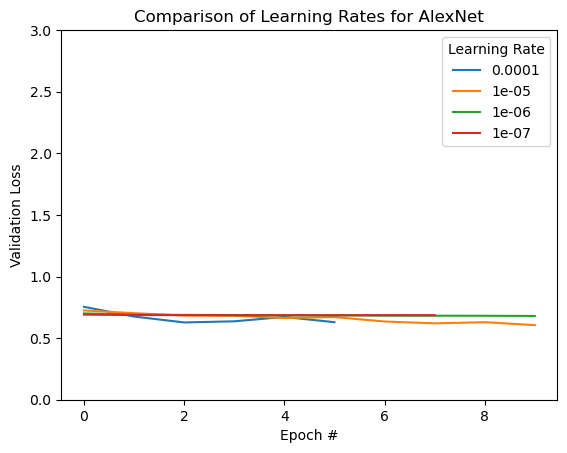

Best learning rate: 1e-05
Lowest val loss: 0.6055


In [24]:
alexnet_learning_rate = best_learning_rate(create_alexnet, "AlexNet")

Learning Rate: 0.0001
Epoch 1/10
25/25 [==============================] - 20s 748ms/step - loss: 0.9505 - accuracy: 0.5238 - precision: 0.6117 - recall: 0.5669 - val_loss: 0.7342 - val_accuracy: 0.5050 - val_precision: 0.5039 - val_recall: 0.6400
Epoch 2/10
25/25 [==============================] - 20s 779ms/step - loss: 0.8335 - accuracy: 0.5500 - precision: 0.5513 - recall: 0.5375 - val_loss: 0.7289 - val_accuracy: 0.4850 - val_precision: 0.4835 - val_recall: 0.4400
Epoch 3/10
25/25 [==============================] - 18s 720ms/step - loss: 0.8243 - accuracy: 0.5587 - precision: 0.5610 - recall: 0.5400 - val_loss: 0.7257 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6100
Epoch 4/10
25/25 [==============================] - 18s 727ms/step - loss: 0.8101 - accuracy: 0.5525 - precision: 0.5507 - recall: 0.5700 - val_loss: 0.7224 - val_accuracy: 0.5050 - val_precision: 0.5041 - val_recall: 0.6200
Epoch 5/10
25/25 [==============================] - 19s 750ms/step - loss: 0.8

25/25 [==============================] - 20s 774ms/step - loss: 1.2190 - accuracy: 0.5163 - precision: 0.5087 - recall: 0.9525 - val_loss: 1.1864 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 8/10
25/25 [==============================] - 19s 735ms/step - loss: 1.2755 - accuracy: 0.4938 - precision: 0.4967 - recall: 0.9275 - val_loss: 1.1856 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 9/10
25/25 [==============================] - 19s 731ms/step - loss: 1.2770 - accuracy: 0.5013 - precision: 0.5007 - recall: 0.9250 - val_loss: 1.1847 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 10/10
25/25 [==============================] - 19s 766ms/step - loss: 1.2811 - accuracy: 0.4925 - precision: 0.4959 - recall: 0.9000 - val_loss: 1.1839 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000


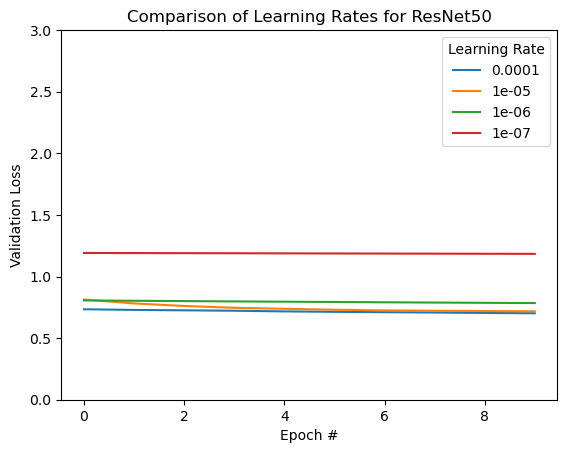

Best learning rate: 0.0001
Lowest val loss: 0.7018


In [25]:
resnet50_learning_rate = best_learning_rate(create_resnet50, "ResNet50")

Learning Rate: 0.0001
Epoch 1/10
25/25 [==============================] - 20s 762ms/step - loss: 0.8464 - accuracy: 0.5213 - precision: 0.5222 - recall: 0.5000 - val_loss: 0.7322 - val_accuracy: 0.5250 - val_precision: 0.5145 - val_recall: 0.8900
Epoch 2/10
25/25 [==============================] - 19s 732ms/step - loss: 0.7674 - accuracy: 0.5688 - precision: 0.5676 - recall: 0.5775 - val_loss: 0.6647 - val_accuracy: 0.5900 - val_precision: 0.5882 - val_recall: 0.6000
Epoch 3/10
25/25 [==============================] - 19s 760ms/step - loss: 0.6979 - accuracy: 0.6062 - precision: 0.6034 - recall: 0.6200 - val_loss: 0.6511 - val_accuracy: 0.5850 - val_precision: 0.5876 - val_recall: 0.5700
Epoch 4/10
25/25 [==============================] - 19s 734ms/step - loss: 0.6651 - accuracy: 0.6300 - precision: 0.6294 - recall: 0.6325 - val_loss: 0.6453 - val_accuracy: 0.5950 - val_precision: 0.5922 - val_recall: 0.6100
Epoch 5/10
25/25 [==============================] - 19s 731ms/step - loss: 0.6

25/25 [==============================] - 19s 743ms/step - loss: 0.9657 - accuracy: 0.4888 - precision: 0.4930 - recall: 0.7900 - val_loss: 0.8430 - val_accuracy: 0.4950 - val_precision: 0.4974 - val_recall: 0.9700
Epoch 8/10
25/25 [==============================] - 19s 742ms/step - loss: 0.9593 - accuracy: 0.4863 - precision: 0.4912 - recall: 0.7675 - val_loss: 0.8400 - val_accuracy: 0.4950 - val_precision: 0.4974 - val_recall: 0.9700
Epoch 9/10
25/25 [==============================] - 18s 725ms/step - loss: 1.0022 - accuracy: 0.4762 - precision: 0.4851 - recall: 0.7725 - val_loss: 0.8367 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9700
Epoch 10/10
25/25 [==============================] - 19s 735ms/step - loss: 0.9181 - accuracy: 0.5113 - precision: 0.5072 - recall: 0.7950 - val_loss: 0.8337 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9700


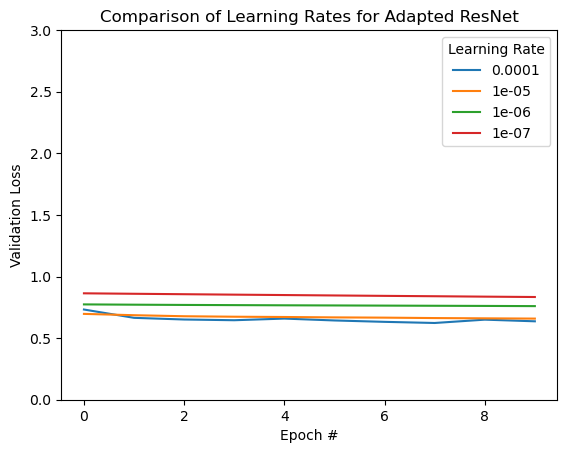

Best learning rate: 0.0001
Lowest val loss: 0.6229


In [26]:
adapted_resnet50_learning_rate = best_learning_rate(create_adapted_resnet50, "Adapted ResNet")

### 2.4.2 Tuning batch size

In [27]:
# function for comparing batch sizes
def best_batch_size(create_model_function,
                        model_name,
                        batch_sizes = [15, 30, 45],
                        learning_rate = 1e-5,
                        num_epochs = 10,
                        train_generator = train_generator500,
                        validataion_generator = validation_generator500
                         ):
    
    # Initialize results list
    results = []

    fig, ax = plt.subplots(1,1)

    # Loop through batch sizes and evaluate
    for batch_size in batch_sizes:
        print(f'Batch Size: {batch_size}')
        train_generator500.batch_size = batch_size
        validation_generator500.batch_size = batch_size  
        
        model = create_model_function(learning_rate = learning_rate)

        cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)

        history = model.fit(train_generator500,
                            validation_data = validation_generator500,
                            epochs = num_epochs,
                            callbacks=[cb_early_stopper]
                            )
        if hasattr(history, 'history_'):
            history = history.history_
        else:
            history = history.history
        history.update({'epoch':list(range(len(history['val_loss'])))})
        history = pd.DataFrame.from_dict(history)

        sns.lineplot(x = 'epoch', y = 'val_loss', data = history, label = f'{batch_size}', ax = ax)
        
        lowest_val_loss = history['val_loss'].min()
        row = (batch_size, lowest_val_loss)
        results.append(row)
        
    ax.set_ylim(ymin=0)
    plt.legend(title='Batch Size')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Validation Loss')
    plt.title(f"Comparison of Batch Sizes for {model_name}")

    plt.show()

    # Determine best batch size
    df = pd.DataFrame(results, columns=['batch_size', 'lowest_val_loss'])
    best_batch_size = df.sort_values('lowest_val_loss').iloc[0,0]
    lowest_val_loss = df['lowest_val_loss'].min()
    print(f'Best batch size: {best_batch_size}')
    print(f'Lowest val loss: {lowest_val_loss:.4f}')

    return best_batch_size

Batch Size: 15
Epoch 1/10
54/54 [==============================] - 16s 286ms/step - loss: 2.5463 - accuracy: 0.5362 - precision: 0.5393 - recall: 0.4975 - val_loss: 0.7363 - val_accuracy: 0.6000 - val_precision: 0.5926 - val_recall: 0.6400
Epoch 2/10
54/54 [==============================] - 15s 276ms/step - loss: 0.8456 - accuracy: 0.5275 - precision: 0.5296 - recall: 0.4925 - val_loss: 0.6927 - val_accuracy: 0.5950 - val_precision: 0.5841 - val_recall: 0.6600
Epoch 3/10
54/54 [==============================] - 15s 277ms/step - loss: 0.7431 - accuracy: 0.5412 - precision: 0.5431 - recall: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5550 - val_precision: 0.5440 - val_recall: 0.6800
Epoch 4/10
54/54 [==============================] - 15s 278ms/step - loss: 0.7198 - accuracy: 0.5362 - precision: 0.5387 - recall: 0.5050 - val_loss: 0.6692 - val_accuracy: 0.6100 - val_precision: 0.5846 - val_recall: 0.7600
Epoch 5/10
54/54 [==============================] - 15s 284ms/step - loss: 0.6823 - a

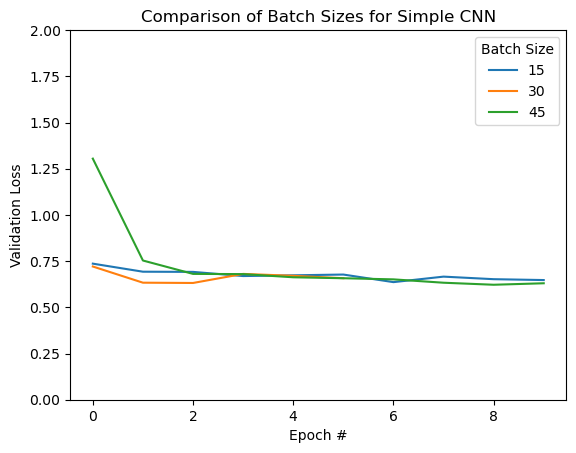

Best batch size: 45
Lowest val loss: 0.6221


In [28]:
cnn_batch_size = best_batch_size(create_cnn, "Simple CNN", learning_rate=cnn_learning_rate)

Batch Size: 15
Epoch 1/10
54/54 [==============================] - 18s 319ms/step - loss: 0.7270 - accuracy: 0.5113 - precision: 0.5110 - recall: 0.5225 - val_loss: 0.7054 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
54/54 [==============================] - 18s 326ms/step - loss: 0.7128 - accuracy: 0.5312 - precision: 0.5300 - recall: 0.5525 - val_loss: 0.6750 - val_accuracy: 0.5400 - val_precision: 0.5230 - val_recall: 0.9100
Epoch 3/10
54/54 [==============================] - 17s 316ms/step - loss: 0.6832 - accuracy: 0.5612 - precision: 0.5636 - recall: 0.5425 - val_loss: 0.6618 - val_accuracy: 0.5900 - val_precision: 0.5556 - val_recall: 0.9000
Epoch 4/10
54/54 [==============================] - 17s 317ms/step - loss: 0.6806 - accuracy: 0.5625 - precision: 0.5648 - recall: 0.5450 - val_loss: 0.6329 - val_accuracy: 0.6450 - val_precision: 0.6883 - val_recall: 0.5300
Epoch 5/10
54/54 [==============================] - 18s 322ms/step - loss: 0.6703 - a

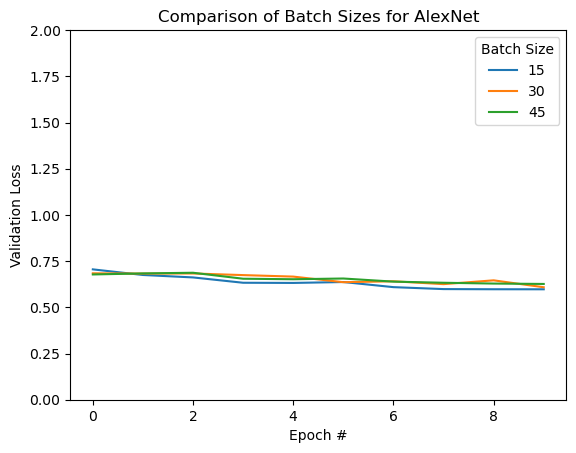

Best batch size: 15
Lowest val loss: 0.5975


In [29]:
alexnet_batch_size = best_batch_size(create_alexnet, "AlexNet", learning_rate=alexnet_learning_rate)

Batch Size: 15
Epoch 1/10
54/54 [==============================] - 21s 369ms/step - loss: 0.9987 - accuracy: 0.4863 - precision: 0.4897 - recall: 0.5220 - val_loss: 0.7502 - val_accuracy: 0.5050 - val_precision: 0.5051 - val_recall: 0.5000
Epoch 2/10
54/54 [==============================] - 20s 373ms/step - loss: 0.9098 - accuracy: 0.5188 - precision: 0.5178 - recall: 0.5450 - val_loss: 0.7355 - val_accuracy: 0.5200 - val_precision: 0.5217 - val_recall: 0.4800
Epoch 3/10
54/54 [==============================] - 20s 375ms/step - loss: 0.9501 - accuracy: 0.4762 - precision: 0.4769 - recall: 0.4900 - val_loss: 0.7326 - val_accuracy: 0.5650 - val_precision: 0.6032 - val_recall: 0.3800
Epoch 4/10
54/54 [==============================] - 20s 369ms/step - loss: 0.8603 - accuracy: 0.5425 - precision: 0.5409 - recall: 0.5625 - val_loss: 0.7170 - val_accuracy: 0.5500 - val_precision: 0.5658 - val_recall: 0.4300
Epoch 5/10
54/54 [==============================] - 20s 367ms/step - loss: 0.8713 - a

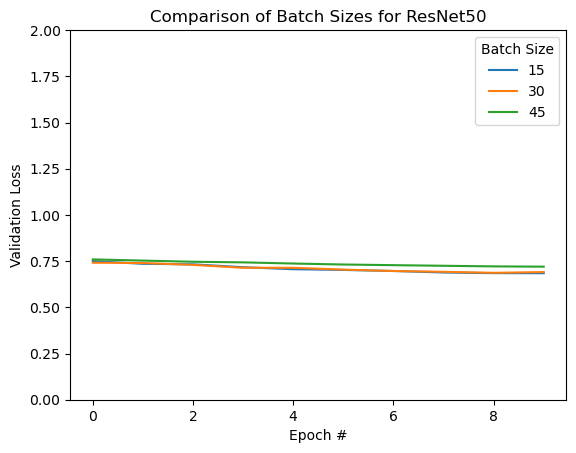

Best batch size: 15
Lowest val loss: 0.6846


In [30]:
resnet50_batch_size = best_batch_size(create_resnet50, "ResNet50", learning_rate=resnet50_learning_rate)

Batch Size: 15
Epoch 1/10
54/54 [==============================] - 22s 387ms/step - loss: 0.8446 - accuracy: 0.5113 - precision: 0.5111 - recall: 0.5175 - val_loss: 0.6810 - val_accuracy: 0.6250 - val_precision: 0.7907 - val_recall: 0.3400
Epoch 2/10
54/54 [==============================] - 19s 356ms/step - loss: 0.7184 - accuracy: 0.5763 - precision: 0.5796 - recall: 0.5550 - val_loss: 0.6589 - val_accuracy: 0.6300 - val_precision: 0.7241 - val_recall: 0.4200
Epoch 3/10
54/54 [==============================] - 20s 364ms/step - loss: 0.6879 - accuracy: 0.6075 - precision: 0.6080 - recall: 0.6050 - val_loss: 0.6356 - val_accuracy: 0.6100 - val_precision: 0.6410 - val_recall: 0.5000
Epoch 4/10
54/54 [==============================] - 20s 373ms/step - loss: 0.6420 - accuracy: 0.6375 - precision: 0.6316 - recall: 0.6600 - val_loss: 0.6800 - val_accuracy: 0.6150 - val_precision: 0.7805 - val_recall: 0.3200
Epoch 5/10
54/54 [==============================] - 20s 362ms/step - loss: 0.6112 - a

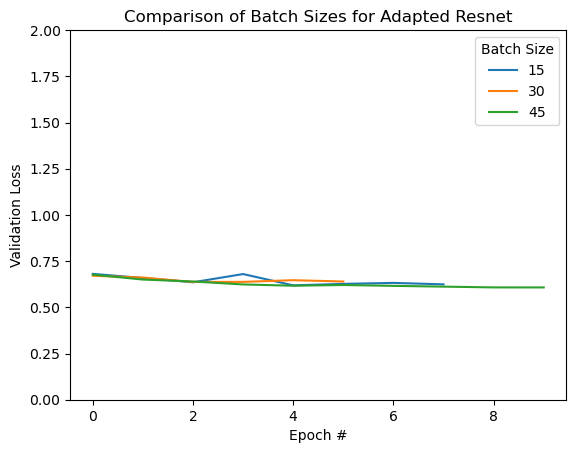

Best batch size: 45
Lowest val loss: 0.6077


In [31]:
adapted_resnet50_batch_size = best_batch_size(create_adapted_resnet50, "Adapted Resnet", learning_rate=adapted_resnet50_learning_rate)

### 2.4.3 Best paramaters

In [32]:
best_learning_rates = [cnn_learning_rate,
                       alexnet_learning_rate,
                       resnet50_learning_rate,
                       adapted_resnet50_learning_rate]
best_batch_sizes = [cnn_batch_size,
                       alexnet_batch_size,
                       resnet50_batch_size,
                       adapted_resnet50_batch_size]
model_results['best_learning_rate'] = best_learning_rates
model_results['best_batch_size'] = best_batch_sizes

In [33]:
model_results

,model_name,create_model_function,initial_val_loss,initial_val_accuracy,initial_val_precision,initial_val_recall,best_learning_rate,best_batch_size
0,Simple CNN,<function create_cnn at 0x16dcbd8a0>,0.615316,0.652878,0.657993,0.636691,0.00010,45
1,AlexNet,<function create_alexnet at 0x16e4044a0>,0.489569,0.776978,0.800781,0.737410,0.00001,15
2,ResNet50,<function create_resnet50 at 0x286addd00>,0.584065,0.674460,0.693227,0.625899,0.00010,15
3,Adapted ResNet50,<function create_adapted_resnet50 at 0x16c9a3060>,0.561103,0.713130,0.729207,0.678058,0.00010,45


## 2.5 Final model comparison

In [34]:
# Initialize list for final results
final_results = []

In [35]:
def evaluate_final_model(model_name, model_results=model_results, epochs=40):
    values = model_results.loc[model_results['model_name'] == model_name]
    create_model_function = values['create_model_function'].iloc[0]
    learning_rate = values['best_learning_rate'].iloc[0]
    batch_size = values['best_batch_size'].iloc[0]
    
    print(model_name)
    model = create_model_function(learning_rate=learning_rate)
    train_generator.batch_size = batch_size
    validation_generator.batch_size = batch_size
    test_generator.batch_size = batch_size

    weights_file_path = '../models/working/'+ model_name +'_best.hdf5'
    cb_checkpointer = ModelCheckpoint(filepath = weights_file_path,
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      mode = 'auto')
    
    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

    print('Training...')
    model_history = model.fit(train_generator,
                                     epochs = epochs,
                                     validation_data = validation_generator,
                                     callbacks=[cb_checkpointer, cb_early_stopper])
    plot_acc_loss(model_history, model_name)
    model.load_weights(weights_file_path)
    print('Evaluating...')
    loss, accuracy, precision, recall = model.evaluate(test_generator,
                      batch_size=cnn_batch_size)
    result = (model_name, model, accuracy, precision, recall)
    return result

Simple CNN
Training...
Epoch 1/40
74/74 [==============================] - 68s 919ms/step - loss: 2.1054 - accuracy: 0.5330 - precision: 0.5335 - recall: 0.5255 - val_loss: 0.6583 - val_accuracy: 0.5926 - val_precision: 0.5705 - val_recall: 0.7500
Epoch 2/40
74/74 [==============================] - 67s 905ms/step - loss: 0.6964 - accuracy: 0.5775 - precision: 0.5789 - recall: 0.5688 - val_loss: 0.6517 - val_accuracy: 0.6151 - val_precision: 0.6049 - val_recall: 0.6637
Epoch 3/40
74/74 [==============================] - 68s 912ms/step - loss: 0.6707 - accuracy: 0.5958 - precision: 0.5964 - recall: 0.5928 - val_loss: 0.6257 - val_accuracy: 0.6358 - val_precision: 0.6208 - val_recall: 0.6978
Epoch 4/40
74/74 [==============================] - 67s 903ms/step - loss: 0.6539 - accuracy: 0.6168 - precision: 0.6215 - recall: 0.5976 - val_loss: 0.6416 - val_accuracy: 0.6376 - val_precision: 0.6571 - val_recall: 0.5755
Epoch 5/40
74/74 [==============================] - 67s 902ms/step - loss: 0.

74/74 [==============================] - 68s 920ms/step - loss: 0.5482 - accuracy: 0.7189 - precision: 0.7341 - recall: 0.6865 - val_loss: 0.5342 - val_accuracy: 0.7167 - val_precision: 0.6898 - val_recall: 0.7878
Epoch 38/40
74/74 [==============================] - 68s 916ms/step - loss: 0.5412 - accuracy: 0.7228 - precision: 0.7290 - recall: 0.7093 - val_loss: 0.5058 - val_accuracy: 0.7410 - val_precision: 0.7815 - val_recall: 0.6691
Epoch 39/40
74/74 [==============================] - 68s 921ms/step - loss: 0.5496 - accuracy: 0.7123 - precision: 0.7324 - recall: 0.6691 - val_loss: 0.5070 - val_accuracy: 0.7482 - val_precision: 0.7782 - val_recall: 0.6942
Epoch 40/40
74/74 [==============================] - 69s 937ms/step - loss: 0.5428 - accuracy: 0.7120 - precision: 0.7226 - recall: 0.6883 - val_loss: 0.5282 - val_accuracy: 0.7428 - val_precision: 0.7733 - val_recall: 0.6871


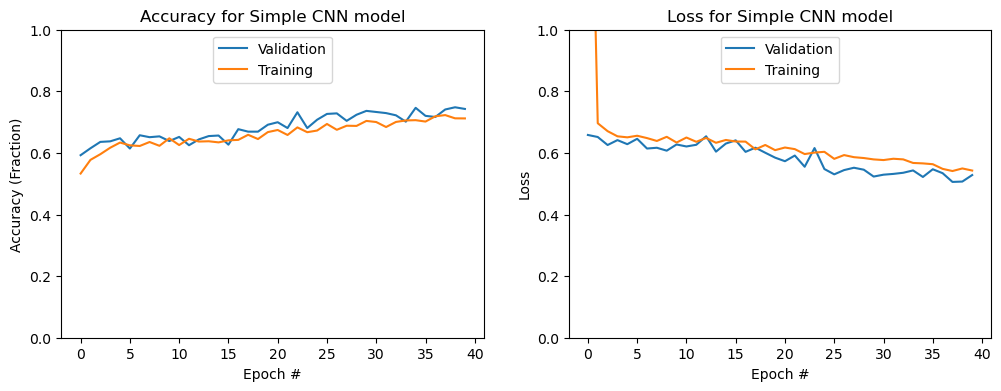

Evaluating...
25/25 [==============================] - 13s 538ms/step - loss: 0.5183 - accuracy: 0.7423 - precision: 0.7762 - recall: 0.6811


In [36]:
cnn_results = evaluate_final_model(model_name='Simple CNN')
final_results.append(cnn_results)

AlexNet
Training...
Epoch 1/40
222/222 [==============================] - 82s 366ms/step - loss: 0.7057 - accuracy: 0.5411 - precision: 0.5411 - recall: 0.5411 - val_loss: 0.6575 - val_accuracy: 0.6196 - val_precision: 0.8482 - val_recall: 0.2914
Epoch 2/40
222/222 [==============================] - 81s 364ms/step - loss: 0.6716 - accuracy: 0.5835 - precision: 0.5882 - recall: 0.5568 - val_loss: 0.6195 - val_accuracy: 0.6700 - val_precision: 0.6998 - val_recall: 0.5953
Epoch 3/40
222/222 [==============================] - 87s 391ms/step - loss: 0.6509 - accuracy: 0.6177 - precision: 0.6217 - recall: 0.6012 - val_loss: 0.6296 - val_accuracy: 0.6646 - val_precision: 0.8453 - val_recall: 0.4029
Epoch 4/40
222/222 [==============================] - 84s 376ms/step - loss: 0.6357 - accuracy: 0.6411 - precision: 0.6484 - recall: 0.6168 - val_loss: 0.6050 - val_accuracy: 0.6933 - val_precision: 0.8098 - val_recall: 0.5054
Epoch 5/40
222/222 [==============================] - 83s 372ms/step - l

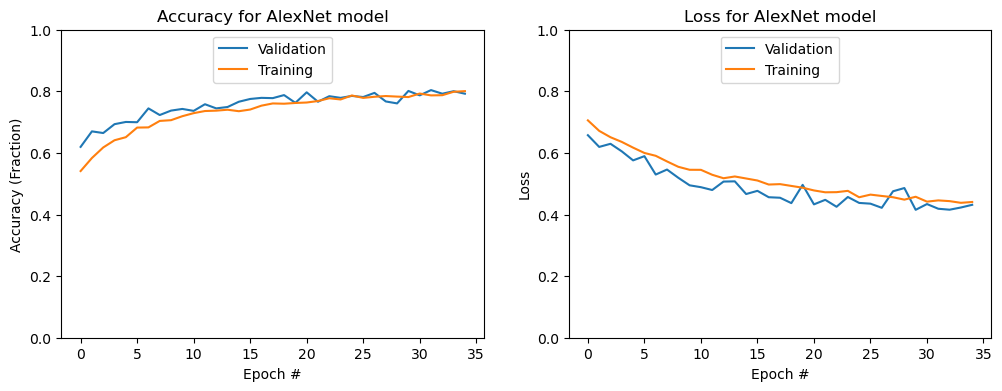

Evaluating...
74/74 [==============================] - 14s 182ms/step - loss: 0.4432 - accuracy: 0.7775 - precision: 0.7984 - recall: 0.7423


In [37]:
an_results = evaluate_final_model(model_name='AlexNet')
final_results.append(an_results)

ResNet50
Training...
Epoch 1/40
222/222 [==============================] - 87s 386ms/step - loss: 0.8774 - accuracy: 0.5237 - precision: 0.5242 - recall: 0.5280 - val_loss: 0.7018 - val_accuracy: 0.5540 - val_precision: 0.5581 - val_recall: 0.5180
Epoch 2/40
222/222 [==============================] - 85s 383ms/step - loss: 0.8350 - accuracy: 0.5420 - precision: 0.5420 - recall: 0.5429 - val_loss: 0.7135 - val_accuracy: 0.5585 - val_precision: 0.6526 - val_recall: 0.2500
Epoch 3/40
222/222 [==============================] - 85s 382ms/step - loss: 0.8246 - accuracy: 0.5309 - precision: 0.5321 - recall: 0.5123 - val_loss: 0.6628 - val_accuracy: 0.5917 - val_precision: 0.6109 - val_recall: 0.5054
Epoch 4/40
222/222 [==============================] - 86s 386ms/step - loss: 0.7942 - accuracy: 0.5562 - precision: 0.5573 - recall: 0.5465 - val_loss: 0.6504 - val_accuracy: 0.6079 - val_precision: 0.6271 - val_recall: 0.5324
Epoch 5/40
222/222 [==============================] - 85s 384ms/step - 

Epoch 37/40
222/222 [==============================] - 82s 370ms/step - loss: 0.5924 - accuracy: 0.6799 - precision: 0.6839 - recall: 0.6691 - val_loss: 0.5688 - val_accuracy: 0.6835 - val_precision: 0.6861 - val_recall: 0.6763
Epoch 38/40
222/222 [==============================] - 84s 377ms/step - loss: 0.5914 - accuracy: 0.6784 - precision: 0.6842 - recall: 0.6625 - val_loss: 0.5681 - val_accuracy: 0.6879 - val_precision: 0.6961 - val_recall: 0.6673
Epoch 39/40
222/222 [==============================] - 83s 373ms/step - loss: 0.5990 - accuracy: 0.6784 - precision: 0.6820 - recall: 0.6685 - val_loss: 0.5750 - val_accuracy: 0.6960 - val_precision: 0.7646 - val_recall: 0.5665
Epoch 40/40
222/222 [==============================] - 83s 372ms/step - loss: 0.6011 - accuracy: 0.6673 - precision: 0.6697 - recall: 0.6601 - val_loss: 0.5705 - val_accuracy: 0.6924 - val_precision: 0.7286 - val_recall: 0.6133


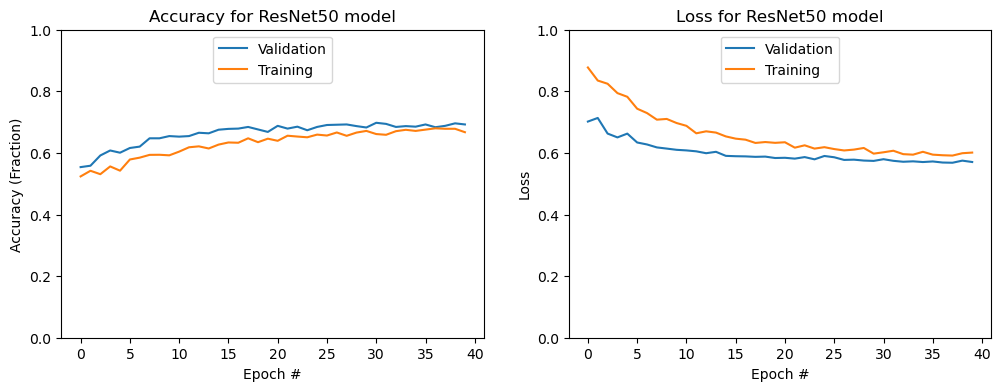

Evaluating...
74/74 [==============================] - 21s 283ms/step - loss: 0.5561 - accuracy: 0.7207 - precision: 0.7298 - recall: 0.7009


In [38]:
rn50_results = evaluate_final_model(model_name='ResNet50')
final_results.append(rn50_results)

Adapted ResNet50
Training...
Epoch 1/40
74/74 [==============================] - 86s 1s/step - loss: 0.7638 - accuracy: 0.5745 - precision: 0.5750 - recall: 0.5712 - val_loss: 0.6120 - val_accuracy: 0.6538 - val_precision: 0.6404 - val_recall: 0.7014
Epoch 2/40
74/74 [==============================] - 85s 1s/step - loss: 0.6676 - accuracy: 0.6162 - precision: 0.6195 - recall: 0.6024 - val_loss: 0.6050 - val_accuracy: 0.6718 - val_precision: 0.6528 - val_recall: 0.7338
Epoch 3/40
74/74 [==============================] - 84s 1s/step - loss: 0.6247 - accuracy: 0.6495 - precision: 0.6533 - recall: 0.6372 - val_loss: 0.5917 - val_accuracy: 0.6700 - val_precision: 0.7105 - val_recall: 0.5737
Epoch 4/40
74/74 [==============================] - 84s 1s/step - loss: 0.6202 - accuracy: 0.6517 - precision: 0.6548 - recall: 0.6414 - val_loss: 0.5988 - val_accuracy: 0.6700 - val_precision: 0.7417 - val_recall: 0.5216
Epoch 5/40
74/74 [==============================] - 86s 1s/step - loss: 0.6144 - ac

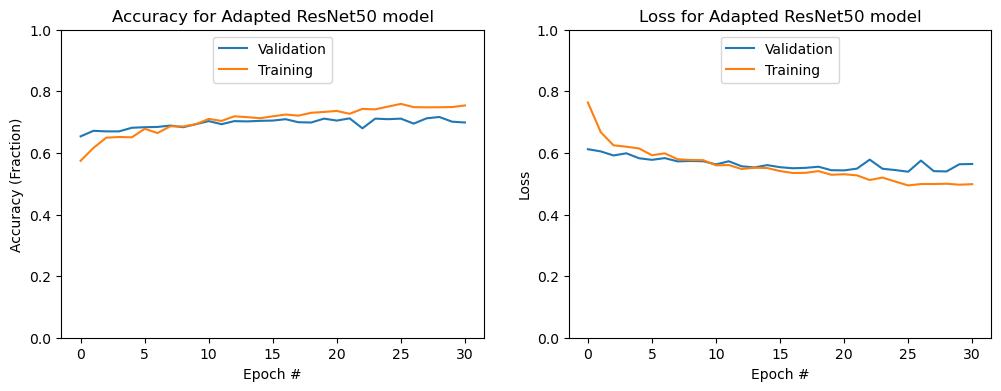

Evaluating...
25/25 [==============================] - 20s 792ms/step - loss: 0.5146 - accuracy: 0.7477 - precision: 0.7523 - recall: 0.7387


In [39]:
adapted_rn50_results = evaluate_final_model(model_name='Adapted ResNet50')
final_results.append(adapted_rn50_results)

In [40]:
final_results_df = pd.DataFrame(final_results, columns=['model_name',
                                                     'model',
                                                     'final_accuracy',
                                                     'final_precision',
                                                     'final_recall'])

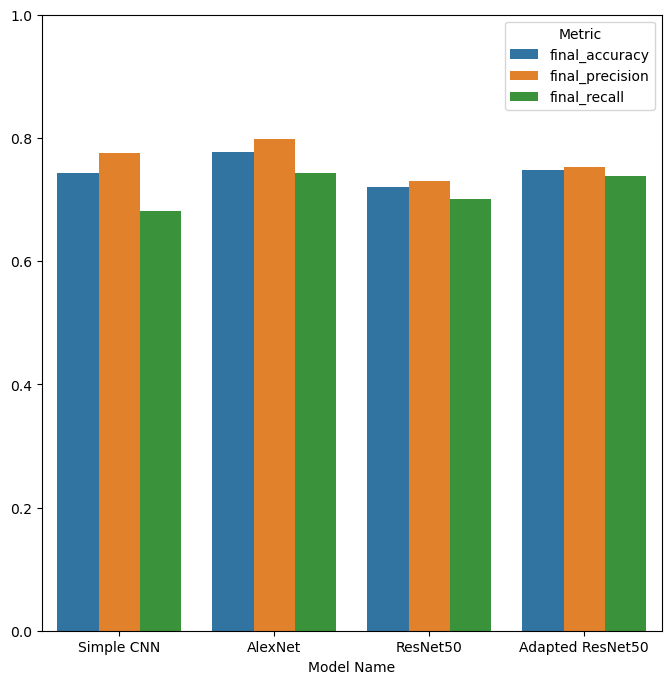

In [41]:
results_melt = final_results_df.drop(columns=['model']).melt(id_vars='model_name')

fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(data=results_melt, x='model_name', y='value', hue='variable')
ax.set_ylabel(None)
ax.set_xlabel('Model Name')
ax.set_ylim(0,1)
plt.legend(title='Metric');

In [42]:
final_results_df = final_results_df.sort_values('final_recall', ascending=False)
best_model = final_results_df.iloc[0,1]

best_model_metrics = final_results_df.head(1).drop(columns='model')
best_model_name = best_model_metrics.iloc[0,0]
best_model_parameters = model_results.loc[model_results['model_name'] == best_model_name]
best_model_metrics['learning_rate'] = best_model_parameters['best_learning_rate']
best_model_metrics['batch_size'] = best_model_parameters['best_batch_size']
best_model_metrics

,model_name,final_accuracy,final_precision,final_recall,learning_rate,batch_size
1,AlexNet,0.777478,0.79845,0.742342,0.00001,15


## 2.6 Understanding our model

In order to understand how the convolutional neural nets are detecting cardiomegaly, I plotted saliency maps for three images.

In [43]:
IMAGE_DIRECTORY = "../data/processed/full/validation/cardiomegaly"

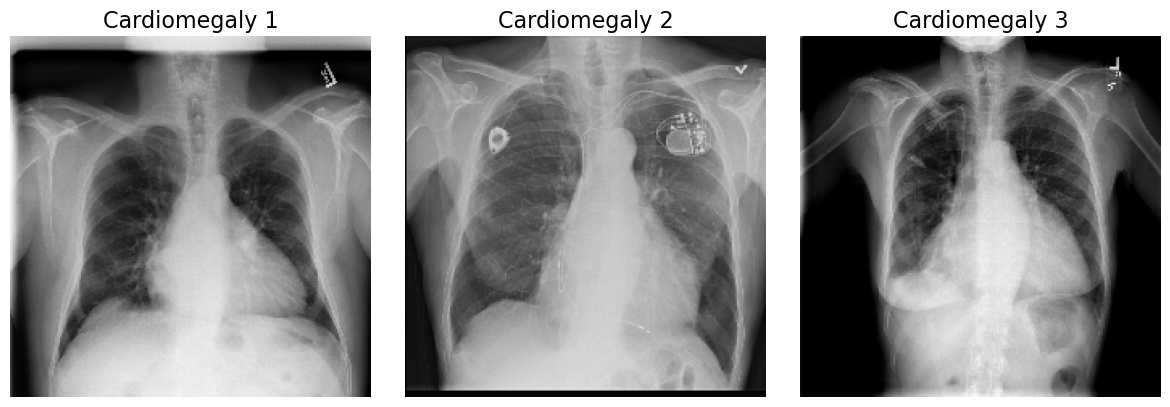

In [44]:
# Image titles
image_titles = ['Cardiomegaly 1', 'Cardiomegaly 2', 'Cardiomegaly 3']

# Load images and Convert them to a Numpy array
img1 = load_img(os.path.join(IMAGE_DIRECTORY, '00000001_001.png'), target_size=(IMAGE_SIZE, IMAGE_SIZE))
img2 = load_img(os.path.join(IMAGE_DIRECTORY, '00000044_002.png'), target_size=(IMAGE_SIZE, IMAGE_SIZE))
img3 = load_img(os.path.join(IMAGE_DIRECTORY, '00000211_010.png'), target_size=(IMAGE_SIZE, IMAGE_SIZE))

images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for ResNet50
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

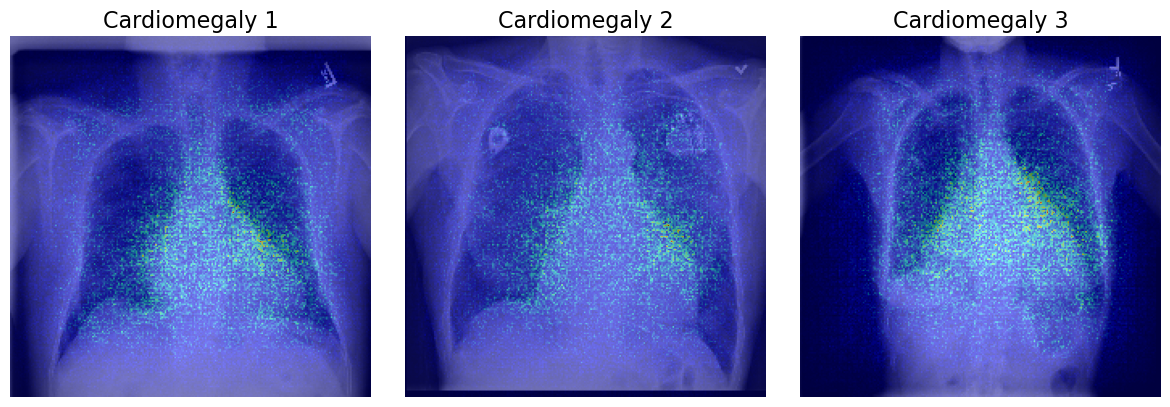

In [45]:
# Create model_modifier
replace2linear = ReplaceToLinear()

# Create score
score = BinaryScore(0.0)

# Create Saliency object.
saliency = Saliency(best_model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(saliency_map[i], cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

The saliency maps all highlight regions around the edge of the heart, particularly where it borders the lungs (the largest dark space on a chest x-ray.

## 2.6 Saving the model

In [46]:
final_model_directory = '../models/final'

# Save model architecture
model_json = best_model.to_json()
arch_path = os.path.join(final_model_directory, "model_arch.json")
with open(arch_path, "w") as json_file:
    json_file.write(model_json)

# Save model weights
weights_path = os.path.join(final_model_directory, "model_weights.h5")
best_model.save_weights(weights_path)

# Save model metics
metrics_path = os.path.join(final_model_directory, "model_metrics.csv")
best_model_metrics.T.to_csv(metrics_path)